# Ocean Proximity with deep artificial neural networks

The vanishing gradient problem: cumulative back-propagated error signals either shrink rapidly, or grow out of bounds. They decay exponentially in the number of layers, or they explode. The result is that the final trained network converges to a poor local minimum.

Activation (non-linear) functions that do not saturate:<br>
Rectifier Linear Unit, ReLU: $y=max(0,x)$, $y \in [0,\infty]$, learning rate $\alpha \rightarrow 0$<br>
Leaky ReLU: $y=max(s·x,x)$ , typically $s=0.01$<br>
Exponential Linear Unit, ELU: $y=s(e^{x}-1$), usually $s=1$. if $s=1$, then $y \in [-1,\infty]$ 

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
%run 1.ReadingData.py

Name of the label file: OceanProximityOneHotEncodedClasses.csv
x_train: (16342, 9)
t_train: (16342, 4)
x_dev: (2043, 9)
t_dev: (2043, 4)
x_test: (2043, 9)
t_test: (2043, 4)


## Initialization

In [3]:
INPUTS = x_train.shape[1]
OUTPUTS = t_train.shape[1]
NUM_TRAINING_EXAMPLES = int(round(x_train.shape[0]/1))
NUM_DEV_EXAMPLES = int (round (x_dev.shape[0]/1))
NUM_TEST_EXAMPLES = int (round (x_test.shape[0]/1))

Some data is displayed to test correctness:

In [4]:
INPUTS

9

In [5]:
OUTPUTS

4

In [6]:
NUM_TRAINING_EXAMPLES

16342

In [7]:
NUM_DEV_EXAMPLES

2043

In [8]:
x_train[:5]

array([[ 0.42031873, -0.66206164, -0.64705882, -0.69739051, -0.58752328,
        -0.82056672, -0.61914159, -0.69639039, -0.60742018],
       [ 0.43027888, -0.98087141, -0.01960784, -0.91784933, -0.91371819,
        -0.84629614, -0.91810557, -0.58127474, -0.78350192],
       [ 0.26294821, -0.72582359, -0.1372549 , -0.94485986, -0.91713222,
        -0.95392248, -0.91810557, -0.72952097, -0.15628802],
       [-0.44621514, -0.05632306, -0.49019608, -0.73401495, -0.74674115,
        -0.85251829, -0.73754317, -0.3834154 ,  0.09195838],
       [-0.39243028,  0.16471838, -0.41176471, -0.86189532, -0.80757294,
        -0.81277502, -0.78885052, -0.7176039 , -0.62350258]])

In [9]:
t_train[:5]

array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]])

In [10]:
x_dev[:5]

array([[-0.07171315, -0.10733262, -0.1372549 , -0.89343303, -0.88081937,
        -0.94910171, -0.86712712, -0.58443332, -0.56041006],
       [-0.4123506 , -0.18384697,  0.49019608, -0.88371738, -0.83612663,
        -0.91894392, -0.86548265, -0.60979849, -0.27587515],
       [-0.61952191,  0.11583422,  1.        , -0.9123048 , -0.88112973,
        -0.96575016, -0.88324289, -0.56120605,  0.99999588],
       [ 0.45418327, -0.9957492 , -0.17647059, -0.88961799, -0.82557418,
        -0.88531069, -0.82798882, -0.79089944, -0.48742067],
       [ 0.15338645, -0.64930925,  0.33333333, -0.96032352, -0.95561763,
        -0.97634463, -0.95428383, -0.31657494, -0.23133925]])

In [11]:
t_dev[:5]

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]])

## Hyperparameters

The number of hidden layers and neurons per layer must be adjusted.

In [12]:
n_epochs = 20000 
learning_rate = 0.1
batch_size = 200
n_neurons_per_layer = [150,75,25,10] 

## Build the model: a 9-150-75-25-10-4 deep neural network architecture

In [13]:
X = tf.placeholder (dtype=tf.float32, shape=(None,INPUTS),name="X")
t = tf.placeholder (dtype=tf.float32, shape=(None,OUTPUTS), name="t")

The deep neural network topology is defined: a full-connected 9-150-75-25-10-4 architecture. The <b>ReLU</b> activation function is chosen for the hidden layers and linear logits with <b>softmax for the ouput layer</b>. 

In [14]:
hidden_layers = []
hidden_layers.append(tf.layers.dense (X, n_neurons_per_layer[0], 
                                      activation = tf.nn.relu))
for layer in range(1,len(n_neurons_per_layer)):
    hidden_layers.append(tf.layers.dense (hidden_layers[layer-1], 
                    n_neurons_per_layer[layer], activation = tf.nn.relu))
net_out = tf.layers.dense (hidden_layers[len(n_neurons_per_layer)-1], OUTPUTS)
y = tf.nn.softmax (logits=net_out, name="y")

In [15]:
for layer in range(len(n_neurons_per_layer)): print (hidden_layers[layer])

Tensor("dense/Relu:0", shape=(?, 150), dtype=float32)
Tensor("dense_1/Relu:0", shape=(?, 75), dtype=float32)
Tensor("dense_2/Relu:0", shape=(?, 25), dtype=float32)
Tensor("dense_3/Relu:0", shape=(?, 10), dtype=float32)


The $log-loss$, $cross-entropy$ (the sun of log-loss is a loss) and and $cost$ (the mean of cross-entropy) functions:

In [16]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2 (labels=t, logits=net_out)
mean_log_loss = tf.reduce_mean (cross_entropy, name="cost")

The training algorithm: gradient descent method with a softmax function at the outputs:

In [17]:
train_step = tf.train.GradientDescentOptimizer (learning_rate).minimize(mean_log_loss)

Model evaluation: accuracy. The percentage of correctly classified instances.

In [18]:
correct_predictions = tf.equal(tf.argmax(y,1),tf.argmax(t,1))
accuracy = tf.reduce_mean(tf.cast(correct_predictions,tf.float32))

## Execute the 9-150-75-25-10-4 deep neural network with M-BGD

In [19]:
init = tf.global_variables_initializer()
accuracy_train_history = []
with tf.Session() as sess:
    sess.run(init)
    for epoch in tqdm(range(n_epochs)):
        offset = (epoch * batch_size) % (NUM_TRAINING_EXAMPLES - batch_size)
        sess.run (train_step, feed_dict={X: x_train[offset:(offset+batch_size)],
                                         t: t_train[offset:(offset+batch_size)]})
        accuracy_train_history.append (accuracy.eval(feed_dict=
                                {X: x_train[offset:(offset+batch_size)],
                                 t: t_train[offset:(offset+batch_size)]}))
    accuracy_train = accuracy.eval(feed_dict={X: x_train[:NUM_TRAINING_EXAMPLES],
                                              t: t_train[:NUM_TRAINING_EXAMPLES]})
    accuracy_dev = accuracy.eval(feed_dict={X: x_dev[:NUM_DEV_EXAMPLES],
                                              t: t_dev[:NUM_DEV_EXAMPLES]})
    
    dev_predictions = y.eval(feed_dict={X: x_dev[:NUM_DEV_EXAMPLES]})
    dev_correct_preditions = correct_predictions.eval (feed_dict=
                                    {X: x_dev[:NUM_DEV_EXAMPLES],
                                     t: t_dev[:NUM_DEV_EXAMPLES]})
    train_mean_log_loss = mean_log_loss.eval (feed_dict=
                                            {X: x_train[:NUM_TRAINING_EXAMPLES],
                                              t: t_train[:NUM_TRAINING_EXAMPLES]})
    dev_mean_log_loss = mean_log_loss.eval (feed_dict=
                                            {X: x_dev[:NUM_DEV_EXAMPLES],
                                              t: t_dev[:NUM_DEV_EXAMPLES]})

100%|██████████| 20000/20000 [04:37<00:00, 72.17it/s]


In [20]:
"Accuracy in training: " + str(accuracy_train)

'Accuracy in training: 0.95275974'

In [21]:
"Maximum accuracy in training: " + str(np.max(accuracy_train_history))

'Maximum accuracy in training: 1.0'

In [22]:
"Accuracy for the development set: " + str(accuracy_dev)

'Accuracy for the development set: 0.9402839'

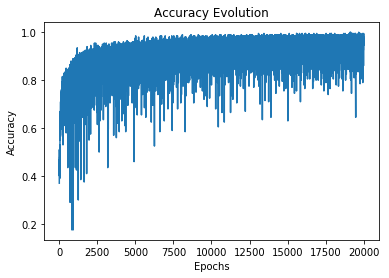

In [23]:
plt.title ("Accuracy Evolution")
plt.xlabel ("Epochs")
plt.ylabel ("Accuracy")
plt.plot (range(n_epochs),accuracy_train_history)

In [24]:
dev_rounded_predictions=np.round(dev_predictions)
indices = np.argmax(dev_predictions,1)
for row, index in zip(dev_rounded_predictions, indices): row[index]=1
dev_rounded_predictions[:10]

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [25]:
t_dev[:10] #target classes

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]])

In [26]:
dev_correct_preditions[:10]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [27]:
train_mean_log_loss

0.11265695

In [28]:
dev_mean_log_loss

0.14140332

<b>Development accuracy has been raised to 94%</b>. Better results have been achieved using 260 hidden neurons than using a one-hidden layer of 1024 units.

<b>NOTE:</b> This neural model can be improved by adding deep learning techniques, tuning the hyperparameters defined in section <b>1.2 Hyperparameters</b> and re-training the neural network until a satisfying model is achieved. Finally, the best architecture must be tested against the final test set.   